In [37]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
from PIL import Image

strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)




from skimage.transform import resize, rotate
import pandas as pd 
from skimage import io, color, filters, feature, restoration
from skimage.transform import resize, rotate
from skimage import data
from skimage.feature._canny import canny
import cv2


Number of replicas: 1
2.13.0


Set Variables to allow quick changes

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [176, 208]
EPOCHS = 100

train_filepath = "./Alz_data/train"
test_file_path = "./Alz_data/test"

# Data Loading

`tf.keras` has a new preprocessing function that can easily load in images for a directory. In order for this function to work, the data has to be structured in a file directory format.

```
main_directory/
    class1/
        class1_images
    class2/
        class2_images
```

If you input the `main_directory` into the `tf.keras` function, it will figure out the rest!
In our case, the `train` directory is our main directory.

We are also specifying a 80:20 split for our training and validation datasets. 

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    # "./Alz_data/train",
    train_filepath, 
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    # "./Alz_data/train",
    train_filepath,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


We'll be renaming the class names and specifying the number of classes. In this case, we have 4 classes of dementia.

In [4]:
class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
train_ds.class_names = class_names
val_ds.class_names = class_names

NUM_CLASSES = len(class_names)

# EDA



In [5]:
(train_ds.take(1))

<_TakeDataset element_spec=(TensorSpec(shape=(None, 176, 208, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

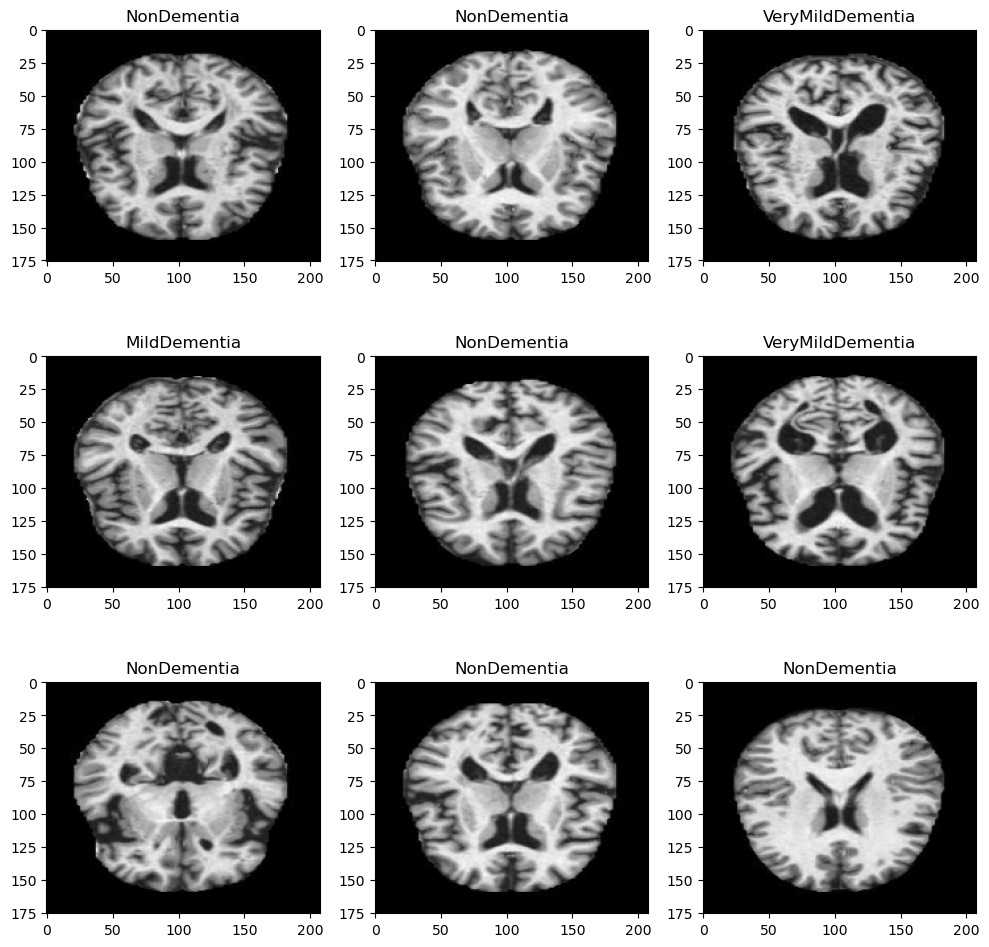

In [6]:
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    # plt.axis("off")
    # plt.show()

# Feature Engineering

we want to convert our model into one-hot encodings because we are working with categorical and noncontinuous data, . One-hot encodings are a way for the model to understand that we're looking at categorial instead of continuous data.

In [7]:
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

The following cell makes calling images from our dataset more efficient.

In [8]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Deciding a Metric

The most conventional metric to use is probably accuracy. Accuracy, however, cannot be used for imbalanced datasets. Let's check how many images are in each class for our training data.

In [9]:
NUM_IMAGES = []

for label in class_names:
    dir_name = "./Alz_data/train/" + label[:-2] + 'ed'
    NUM_IMAGES.append(len([name for name in os.listdir(dir_name)]))

In [10]:
NUM_IMAGES

[718, 53, 2560, 1792]

Since dataset is not balanced, so we cannot use accuracy as our metric. Instead, we will be using ROC AUC. Intuitively, ROC AUC gives a score, with higher scores closer to 1 indicating that the different classes can be distinguishable for the model. A lower score closer indicates that the the model cannot distinguish between different classes. A score of 0.5 indicates that the ordering the images is close to random.

# Build the ML Model



In [11]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [12]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [13]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model

In [14]:
with strategy.scope():
    model = build_model()

    METRICS = [tf.keras.metrics.AUC(name='auc')]
    
    model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

# Training the Model

To more efficiently train our model. We will be using callbacks to adjust the learning rate and to stop the model once it converges.



In [15]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [16]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=EPOCHS
)

Epoch 1/100
257/257 [==============================] - 38s 145ms/step - loss: 1.1146 - auc: 0.7758 - val_loss: 6.5894 - val_auc: 0.6987 - lr: 0.0100
Epoch 2/100


/Users/cpsantos/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


257/257 [==============================] - 39s 150ms/step - loss: 0.9943 - auc: 0.8009 - val_loss: 2.1994 - val_auc: 0.8015 - lr: 0.0089
Epoch 3/100
257/257 [==============================] - 38s 147ms/step - loss: 0.9666 - auc: 0.8136 - val_loss: 2.2316 - val_auc: 0.6960 - lr: 0.0079
Epoch 4/100
257/257 [==============================] - 40s 156ms/step - loss: 0.9495 - auc: 0.8184 - val_loss: 1.4333 - val_auc: 0.7454 - lr: 0.0071
Epoch 5/100
257/257 [==============================] - 40s 154ms/step - loss: 0.9448 - auc: 0.8218 - val_loss: 1.9579 - val_auc: 0.7989 - lr: 0.0063
Epoch 6/100
257/257 [==============================] - 40s 155ms/step - loss: 0.9313 - auc: 0.8277 - val_loss: 0.8798 - val_auc: 0.8548 - lr: 0.0056
Epoch 7/100
257/257 [==============================] - 40s 154ms/step - loss: 0.9166 - auc: 0.8344 - val_loss: 1.2126 - val_auc: 0.6576 - lr: 0.0050
Epoch 8/100
257/257 [==============================] - 37s 145ms/step - loss: 0.8980 - auc: 0.8412 - val_loss: 0.8823 

In [20]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 176, 208, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 208, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 88, 104, 16)       0         
 D)                                                              
                                                                 
 sequential (Sequential)     (None, 44, 52, 32)        2160      
                                                                 
 sequential_1 (Sequential)   (None, 22, 26, 64)        7392      
                                                                 
 sequential_2 (Sequential)   (None, 11, 13, 128)       27072     
                                                      

# Visualize Model Metrics

Let's graph the ROC AUC metric and loss after each epoch for the training and validation data.

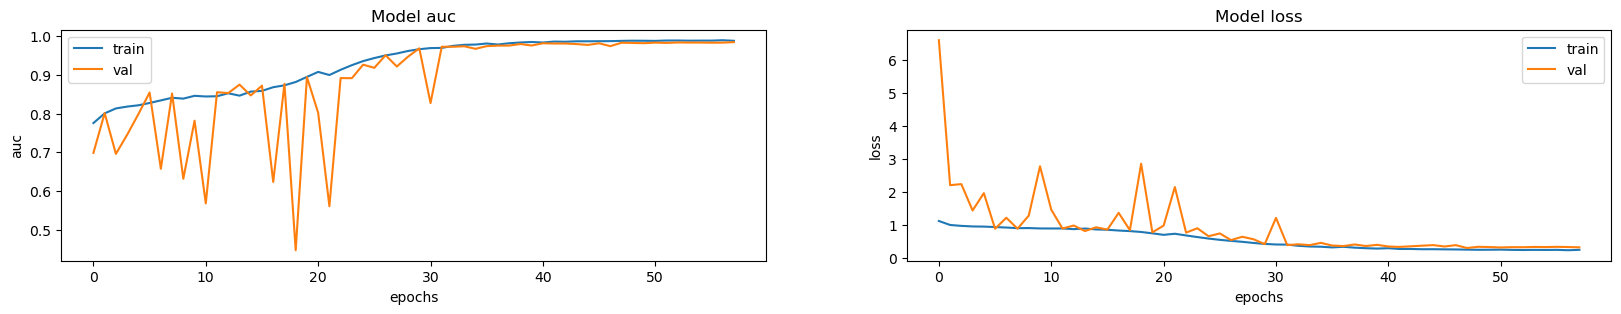

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# Evaluate Model Performance

Although we used the validatation dataset to continually evaluate the model, we also have a separate testing dataset. Let's prepare the validation dataset.

In [18]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./Alz_data/test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1279 files belonging to 4 classes.


In [19]:
_ = model.evaluate(test_ds)

80/80 [==============================] - 3s 37ms/step - loss: 1.2357 - auc: 0.8790


# Future Directions
## Hyperparameter tuning ( things to try)
Learning Rate: This is one of the most crucial hyperparameters. If set too high, the model might overshoot the optimal solution. If set too low, the training might be very slow or get stuck in local minima. It's common to use learning rate schedules or adaptative learning rates (e.g., Adam optimizer) to adjust the learning rate during training.

Batch Size: The number of samples that are used to update the model's weights in one iteration. Smaller batch sizes can lead to a regularizing effect and lower generalization error, but they can also be noisier and slower. Larger batches can be faster but might converge to sharper minima.

Number of Epochs: The number of times the learning algorithm will work through the entire training dataset. Too few might underfit, too many might lead to overfitting, especially if you're not using early stopping.

Optimizer: Algorithms like Adam, RMSprop, and SGD (with or without momentum) are popular choices. Each optimizer has its own set of hyperparameters, like momentum for SGD.

Layer-specific parameters:

Number of Layers: The depth of the neural network. More layers allow for more complexity but also introduce the risk of overfitting.
Number of Units/Neurons: For fully connected layers (Dense layers in Keras), the number of neurons is an important hyperparameter.
Activation Functions: Common choices include ReLU, Leaky ReLU, tanh, and sigmoid.
Dropout Rate: If you're using dropout regularization, tuning the rate (i.e., the fraction of the input units to drop) is crucial. It can help prevent overfitting.


Because training a model is quite computationally expensive to do locally and with limited cpu/gpu power. Trying all these parameters proved to be too time consuming but with more time and resources a better model could likely be found/optimized.


# More EDA Imaging

In [74]:
import glob
non_demented = glob.glob('./Alz_data/train/NonDemented/*.jpg')
mod_demented = glob.glob('./Alz_data/train/ModerateDemented/*.jpg')
mild_demented = glob.glob('./Alz_data/train/MildDemented/*.jpg')
very_mild_demented = glob.glob('./Alz_data/train/VeryMildDemented/*.jpg')

In [75]:
def array(filepath):
    x = np.array([np.array(Image.open(fname)) for fname in filepath])
    return x

In [76]:
nd = array(non_demented)
mild = array(mild_demented)
very_mild = array(very_mild_demented)
mod = array(mod_demented)

In [77]:
pre = [nd[0], very_mild[4], mild[6], mod[0]]

In [78]:
def graph_averages(imgs):    
    fig, axs = plt.subplots(2,2, figsize=(10,10), dpi=150)
    for idx, ax in enumerate(axs.flatten()):
        ax.imshow(imgs[idx], cmap="gray")
    axs[0,0].set_title('No Dementia', fontsize=16)
    axs[0,1].set_title('Very Mild', fontsize=16)
    axs[1,0].set_title('Mild', fontsize=16)
    axs[1,1].set_title('Moderate', fontsize=16)
    axs[0,0].tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
    axs[0,1].tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
    axs[1,0].tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
    axs[1,1].tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
    plt.tight_layout()
    # plt.savefig('../images/4imgs_eda.jpg')
    plt.show()

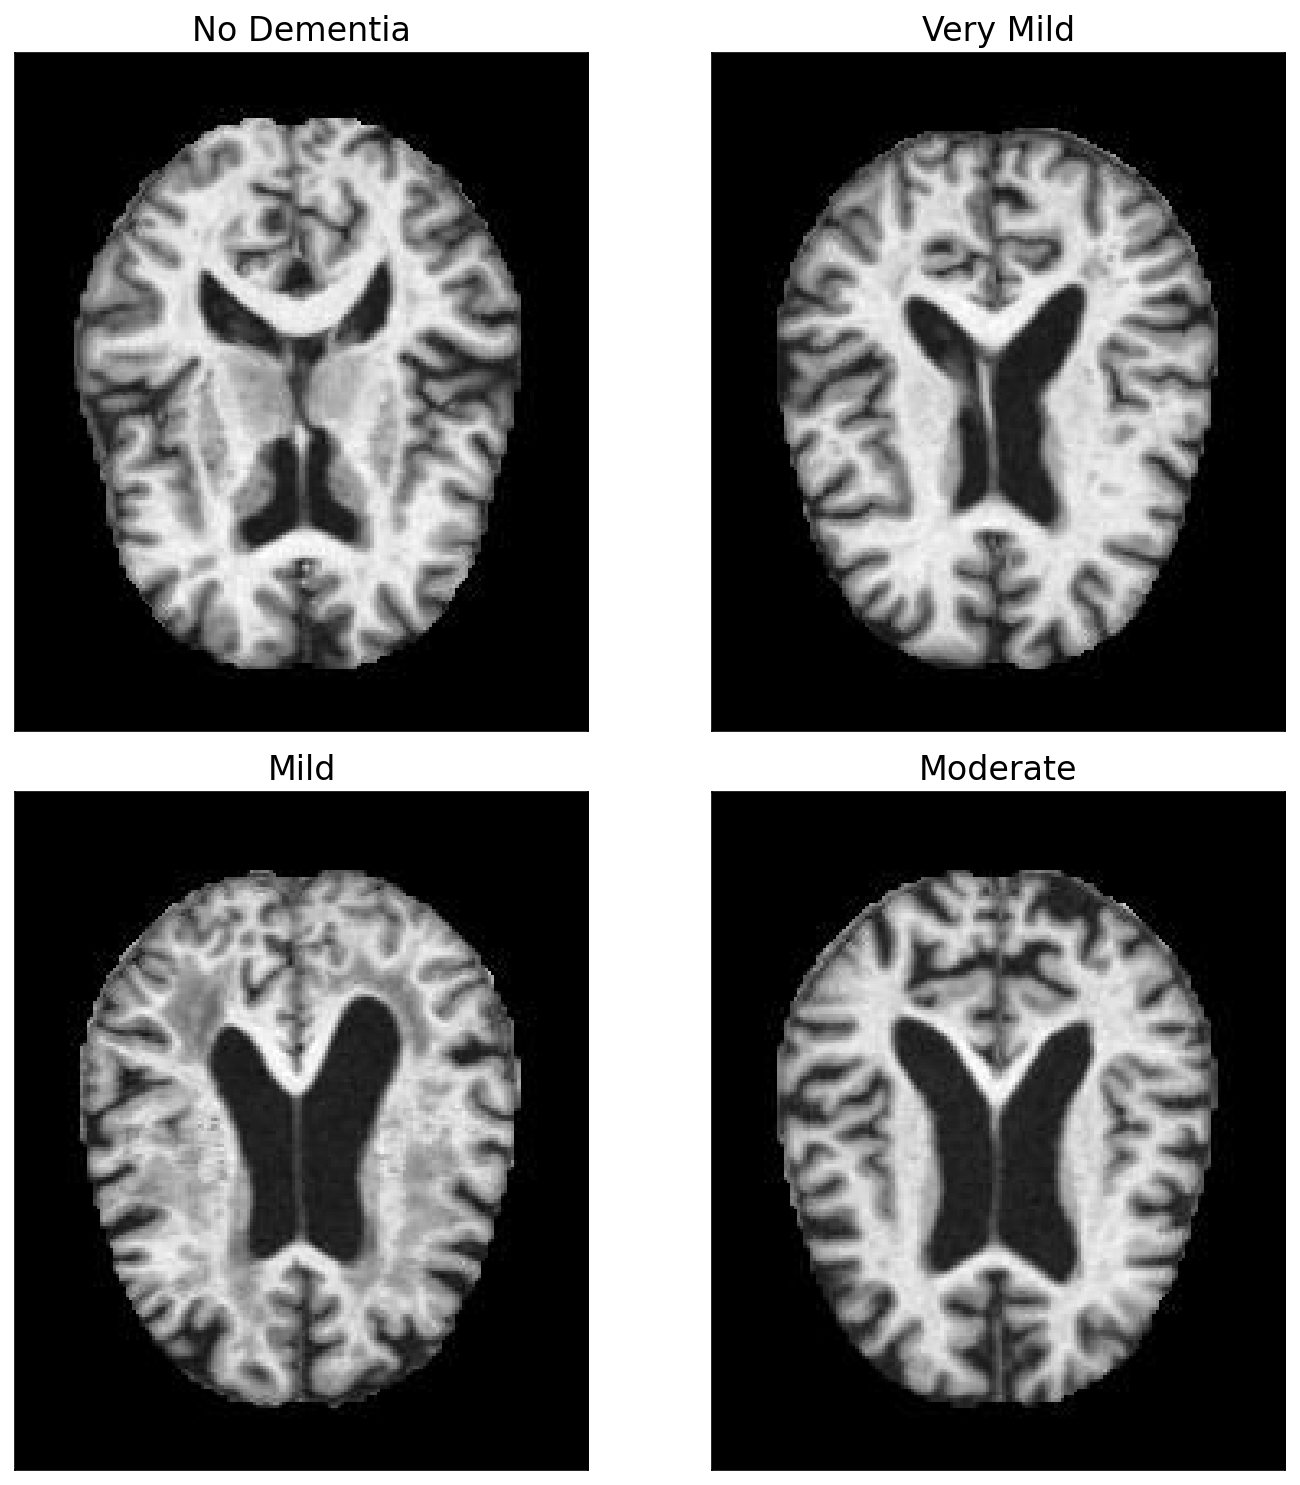

In [79]:
graph_averages(pre)

In [80]:
def graph_averages(imgs):    
    fig, axs = plt.subplots(1,2, figsize=(10,10))
    for idx, ax in enumerate(axs.flatten()):
        ax.imshow(imgs[idx], cmap="gray")
    axs[0].set_title('Moderate Demented Average')
    axs[1].set_title('Non-Demented Average')
    axs[0].tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
    axs[1].tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
    plt.tight_layout()
    # plt.savefig('../images/the_data.jpg')
    plt.show()

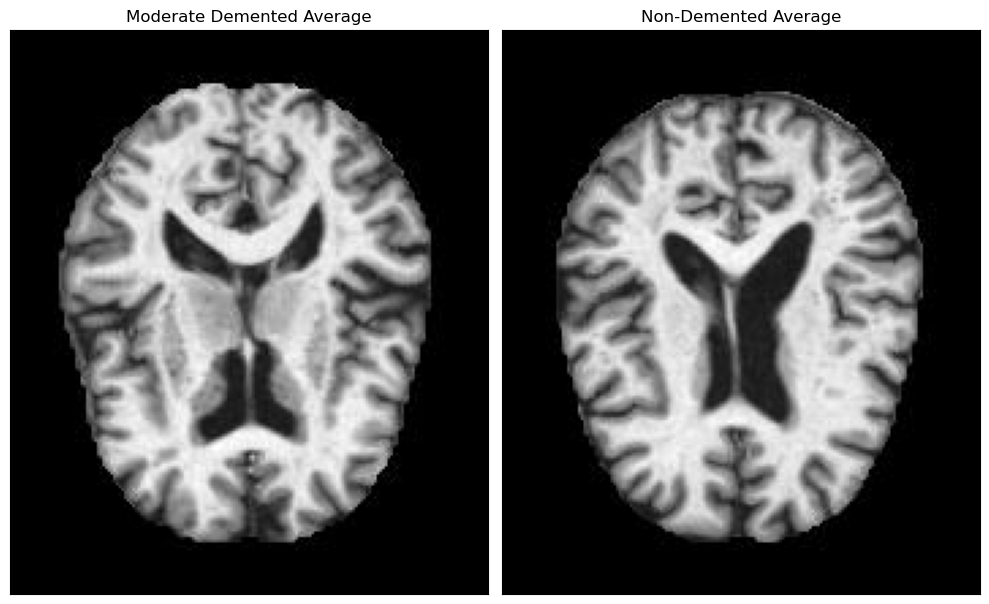

In [81]:
graph_averages(pre)

In [67]:
def graph_averages(imgs):    
    fig, axs = plt.subplots(2,2, figsize=(10,10), dpi=150)
    for idx, ax in enumerate(axs.flatten()):
        ax.imshow(imgs[idx], cmap="gray")
    axs[0,0].set_title('No Dementia', fontsize=16)
    axs[0,1].set_title('Very Mild', fontsize=16)
    axs[1,0].set_title('Mild', fontsize=16)
    axs[1,1].set_title('Moderate', fontsize=16)
    axs[0,0].tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
    axs[0,1].tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
    axs[1,0].tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
    axs[1,1].tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
    plt.tight_layout()
    plt.savefig('../images/4imgs_eda.jpg')
    plt.show()
    
def resize_gray_mat(filelist):
    x = []
    for fname in filelist:
        vec = np.array(Image.open(fname))
        rs = resize(vec, (64,64))
        img = color.rgb2gray(rs)
        x.append(img)
    return np.array(x)

In [82]:
def files_to_array(name, filepath):
    """Takes the filepath of images and imports them. Output is into a numpy array """
    name = glob.glob(filepath)
    x = np.array([np.array(Image.open(fname)) for fname in filepath])
    return x


In [85]:
# nd = files_to_array(non_demented, '../Alz_data/train/NonDemented/')

In [108]:
def resize_gray_mat(filelist):
    x = []
    for fname in filelist:
        vec = np.array(Image.open(fname))
        print(vec.shape)
        rs = resize(vec, (64,64))
        print(rs)
        img = color.rgb2gray(rs)
        x.append(img)
    return np.array(x)

In [109]:
def find_mean_img(full_mat, title):
    mean_img = full_mat.mean(axis = 0)
    plt.imshow(mean_img, cmap='Greys_r')
    plt.axis('off')
    plt.show()
    return mean_img

In [ ]:
# non_demented

In [113]:
non_dem_avg = find_mean_img(non_demented, "Non Demented")

In [124]:
non_demented[0]

'./Alz_data/train/NonDemented/nonDem1498.jpg'

In [125]:
from PIL import Image
import os
import numpy as np

def average_images(image_files):
    # Open the first image and convert it to RGB
    base_img = Image.open(image_files[0]).convert('RGB')
    base_array = np.array(base_img, dtype=np.float32)

    # Add all other images to the base image
    for file in image_files[1:]:
        img = Image.open(file).convert('RGB')
        img_array = np.array(img, dtype=np.float32)

        # Make sure all images are of the same size
        if base_img.size != img.size:
            raise ValueError(f"All images should be of the same size. {file} is of different size.")

        base_array += img_array

    # Calculate the average
    base_array /= len(image_files)
    
    # Convert back to 8-bit image
    average_img_rgb = Image.fromarray(np.uint8(base_array))
    average_img = average_img_rgb.convert('L')  # Convert to grayscale

    return average_img

# # Assuming you have your jpg files in the current directory
# image_files = [f for f in os.listdir('.') if f.endswith('.jpg')]

# if not image_files:
#     print("No jpg files found!")
# else:
#     avg_img = average_images(image_files)
#     avg_img.show()  # To display the averaged image
#     avg_img.save('average_greyscale.jpg')  # To save the averaged image


In [128]:
avg_img = average_images(non_demented)
avg_img.show()  # To display the averaged image
# avg_img.save('average_greyscale.jpg')  # To save the averaged image

In [127]:
# base_img = Image.open(non_demented[0]).convert('RGB').convert('F')

In [130]:
avg_img = average_images(non_demented)
avg_img.show()  # To display the averaged image

In [131]:
avg_img = average_images(mild_demented)
avg_img.show()  # To display the averaged image

In [132]:
avg_img = average_images(very_mild_demented)
avg_img.show()  # To display the averaged image

In [133]:
avg_img = average_images(mod_demented)
avg_img.show()  # To display the averaged image

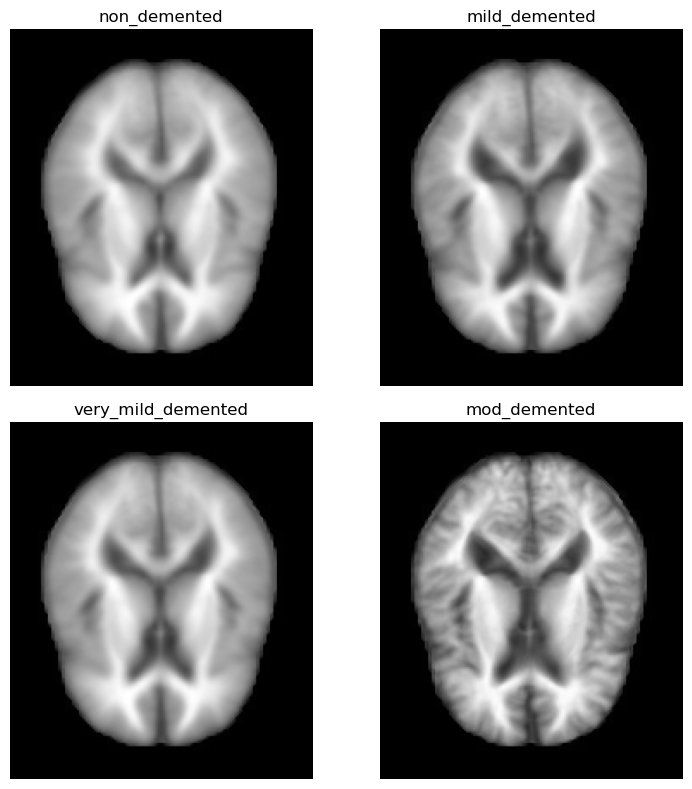

In [141]:
categories = ["non_demented", "mild_demented", "very_mild_demented", "mod_demented"]
image_files_lists = [non_demented, mild_demented, very_mild_demented, mod_demented]

averaged_images = [average_images(files) for files in image_files_lists]



fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for i in range(2):
    for j in range(2):
        idx = 2*i + j
        axes[i, j].imshow(averaged_images[idx], cmap='gray')
        axes[i, j].set_title(categories[idx])
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()